# Import Libraries

In [1]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import nltk
nltk.download('stopwords')
import scapy
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
from textblob import TextBlob

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#transformers

#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

#os and warnings
import os
import random
import warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
warnings.filterwarnings('ignore')
nltk.download('punkt')

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_score , recall_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils import resample

import logging

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Figure size 640x480 with 0 Axes>

# Load Data

In [2]:
df = pd.read_csv("BRAD.tsv",sep='\t')
df.columns = ['label' , 'ID1' , 'ID2' , 'ID3' , 'sentence']
cleaned = df.drop(['ID1' , 'ID2' , 'ID3'], axis=1)
cleaned.head()

,label,sentence
0,5,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...
1,4,رواية تلامس الروح بعمقها، فخورة اني اخيرا لقيت...
2,5,رواية محكمة بكل اختصار. وكان الجزء المفضل بالن...
3,3,هذا الكتاب يحزن مرا، ظلم واضطهاد عيسى بلا ذنب ...
4,4,رواية واقعية ورائعة تمثل أحداث تكررت كثيرا في ...


# Preprocessing and text Cleaning

In [3]:
def mark_sentiment(rating):
    if(rating<3):
        return 0
    else:
        return 1

In [4]:
cleaned['label'] = cleaned['label'].apply(lambda x:mark_sentiment(x))
cleaned.head()

,label,sentence
0,1,كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله و...
1,1,رواية تلامس الروح بعمقها، فخورة اني اخيرا لقيت...
2,1,رواية محكمة بكل اختصار. وكان الجزء المفضل بالن...
3,1,هذا الكتاب يحزن مرا، ظلم واضطهاد عيسى بلا ذنب ...
4,1,رواية واقعية ورائعة تمثل أحداث تكررت كثيرا في ...


In [5]:
stops = set(stopwords.words("arabic"))
stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين","اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","كان","ّأيّان"}

In [6]:
st = ISRIStemmer()
def stemNLTK(text):
    # tokenize
    zen = TextBlob(text)
    words = zen.words
    cleaned = list()
    for w in words:
        ty = st.stem(w)
        cleaned.append(ty)
    return " ".join(cleaned)

stemNLTK("كتاب رائع. اعتقد ان الروايه كلها تلخصت بجمله ")

'كتب رئع عقد ان ريه كله لخص جمل'

In [7]:
def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

normalizeArabic("مَرَّتْ أوَانَ العِيدِ بَيْنَ نَوَاهِدٍ مِثْلِ الشُّمُوسِ لِحَاظُهُنَّ ظِبَاء")

'مرت اوان العيد بين نواهد مثل الشموس لحاظهن ظباء'

In [8]:
def remove_stop_words(text):
    zen = TextBlob(text)
    words = zen.words
    return " ".join([w for w in words if not w in stops and not w in stop_word_comp and len(w) >= 2])

remove_stop_words("مرت اوان العيد بين نواهد مثل الشموس لحاظهن ظباء")

'مرت اوان العيد نواهد الشموس لحاظهن ظباء'

In [9]:
def clean_text(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)  # remove punctuation
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    ## Convert text to lowercases
    text = text.lower()
    ## Remove stop words
    text = remove_stop_words(text)
    ## Remove numbers
    text = re.sub("\d+", " ", text)
    ## Remove Tashkeel
    text = normalizeArabic(text)
    #text = re.sub('\W+', ' ', text)
    text = re.sub('[A-Za-z]+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    #Stemming
    text = stemNLTK(text)
    return text

In [10]:
%time
cleaned['sentence'] = cleaned['sentence'].apply(lambda x:clean_text(x))
cleaned.head()

Wall time: 0 ns


,label,sentence
0,1,كتب رءع عقد ريه كله لخص جمل وحد عطء حب قيم
1,1,ريه لمس روح عمق فخر اني اخر لقت ريه عرب كتب به...
2,1,ريه حكم بكل خصر جزء فضل نسب وصف كتب حيه عيس فل...
3,1,كتب يحز مرا ظلم ضطهاد عيس بلا ذنب فصل كتب خلف ...
4,1,ريه وقع رءع مثل حدث كرر جمع خلج ونا تثر لني عش...


In [11]:
cleaned['sentence'].duplicated().sum()

15022

In [12]:
cleaned.drop_duplicates("sentence", inplace=True)
data = cleaned

# Balancing Data Classes

In [13]:
data.label.value_counts()

1    419273
0     76303
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

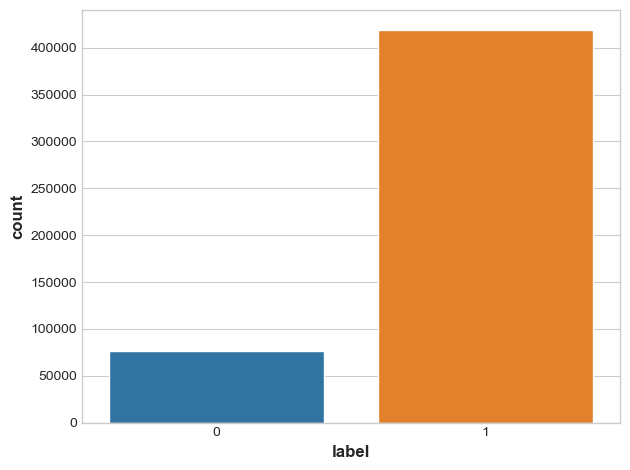

In [14]:
sns.countplot(x=data["label"])

In [15]:
datasetNeg , datasetPos, = (g for _,g in data.groupby('label'))

In [16]:
print(datasetNeg.shape)
datasetNeg.head()

(76303, 2)


,label,sentence
45,0,قرت فتر طول حضر عجب جنب انس مكن دخل ذكر اني شع...
47,0,نفس احب ريه دي غلب صدقاء الل قرو صفو بان مش رء...
67,0,عمل سلسل اجف سلسل اقر ريه حتر
70,0,لطف كنك فرج سلسل نوع لطف
72,0,ريه جمل حمل معا رسل كثر ارد كتب ورء يصل فكر تع...


In [17]:
print(datasetPos.shape)
datasetPos.head()

(419273, 2)


,label,sentence
0,1,كتب رءع عقد ريه كله لخص جمل وحد عطء حب قيم
1,1,ريه لمس روح عمق فخر اني اخر لقت ريه عرب كتب به...
2,1,ريه حكم بكل خصر جزء فضل نسب وصف كتب حيه عيس فل...
3,1,كتب يحز مرا ظلم ضطهاد عيس بلا ذنب فصل كتب خلف ...
4,1,ريه وقع رءع مثل حدث كرر جمع خلج ونا تثر لني عش...


In [18]:
datasetPos = datasetPos.iloc[(419115 -76295 ) : ]

In [19]:
print(datasetPos.shape)
datasetPos.head()

(76453, 2)


,label,sentence
416908,1,جمع قصص رهب درج اني خلص فكر رجع اقر مره ثني
416909,1,جمع قصص جمل بدع نجب نهي عنب ولو قصص اثر فيا حد...
416910,1,كتب اسم حكي بلا بدي خبر نهي بدي عظم روي خمس عك...
416911,1,جزء عبقر نجب حفظ صفح جمل حره عشق هوه روي حمد ر...
416912,1,عده نجب حفظ فضل كتب روي


In [20]:
data = pd.concat([datasetPos,datasetNeg])

In [21]:
print(data.shape)
data.head()

(152756, 2)


,label,sentence
416908,1,جمع قصص رهب درج اني خلص فكر رجع اقر مره ثني
416909,1,جمع قصص جمل بدع نجب نهي عنب ولو قصص اثر فيا حد...
416910,1,كتب اسم حكي بلا بدي خبر نهي بدي عظم روي خمس عك...
416911,1,جزء عبقر نجب حفظ صفح جمل حره عشق هوه روي حمد ر...
416912,1,عده نجب حفظ فضل كتب روي


In [22]:
data.label.value_counts()

1    76453
0    76303
Name: label, dtype: int64

In [23]:
text_len = []
for text in data.sentence:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
    
data['text_len'] = text_len

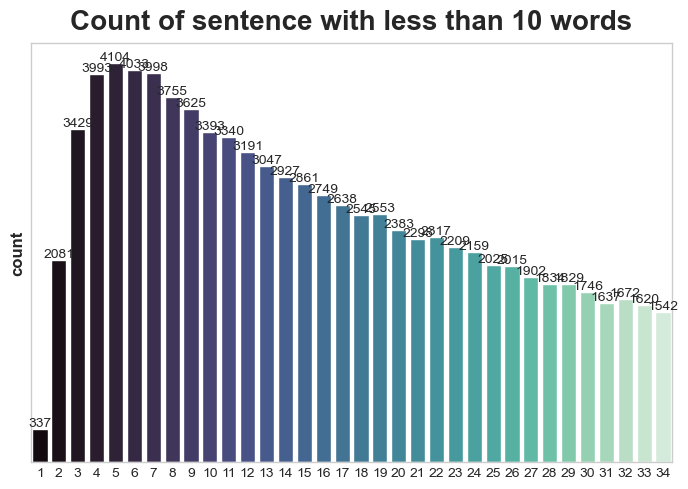

In [24]:
plt.figure(figsize=(7,5))

ax = sns.countplot(x='text_len', data=data[data['text_len'] < 35 ], palette='mako')
plt.title('Count of sentence with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [25]:
data.sort_values(by=['text_len'], ascending=False)

,label,sentence,text_len
501177,0,عقد غلط طبع اسم فرض يبق اسم فرق نجي عطا الل لل...,1202
255940,0,حذر ريفيو ده مكن قلل ادب حقق غلب هيك قلل ادب ر...,1123
485058,1,فءد حدد تجل ديو صور عبر تلطخ بمل دوخ يعا فءد ح...,1122
360515,0,ذكر اتي خلف كتب واي نشر نزي خلي نبد بدي بدي رخ...,1107
253990,0,عقد مكن تغر اسم كتب نسب كتر تاه فتي وف نسب تني...,1100
...,...,...,...
150668,0,سفف,1
456798,1,حممل,1
42742,0,سحق,1
14144,0,ريه,1


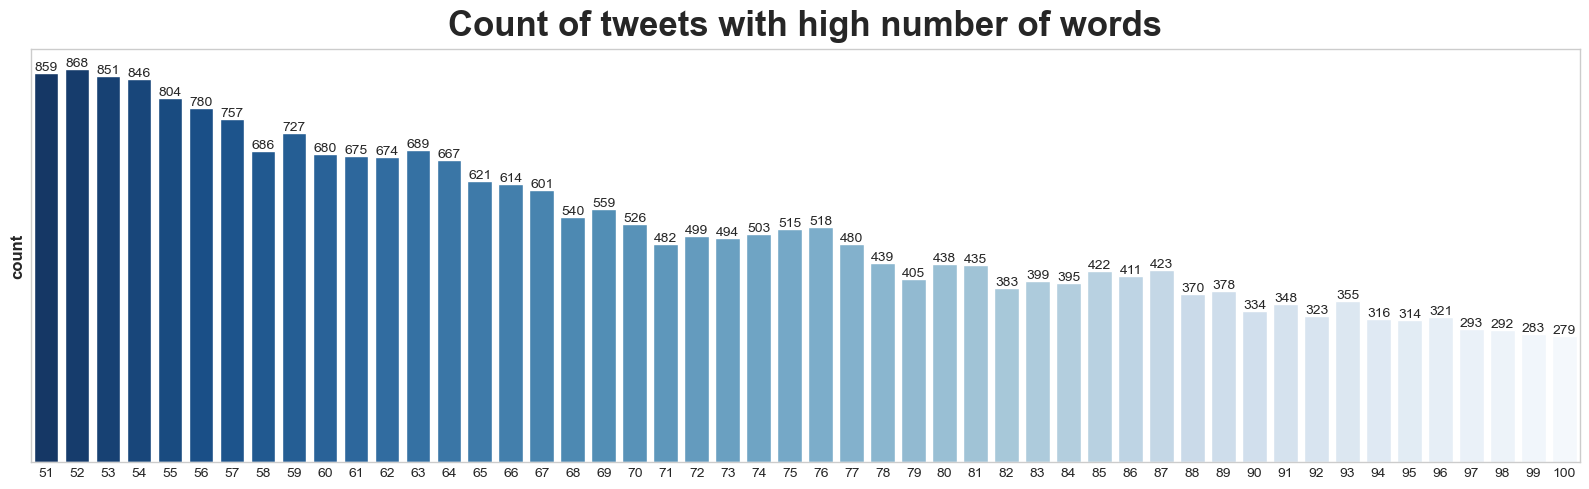

In [26]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=data[(data['text_len']<=100) & (data['text_len']>50)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [27]:
data = data[data['text_len'] <= 100]
data = data[data['text_len'] > 1]

In [28]:
max_len = np.max(data['text_len'])
max_len 

100

In [29]:
data.label.value_counts()

0    67539
1    64407
Name: label, dtype: int64

In [30]:
data.sort_values(by=["text_len"], ascending=False)

,label,sentence,text_len
250779,0,ريه كرا ضعف نسب جذب وخص اني قرت بعد قرت دره عم...,100
299375,0,حذر ءلف ولو كويلو جعل جمل تحي وجه نظر فصل كتب ...,100
418067,1,فلم هزم ميد قتل دار حول ختل ميد بنء صنع قبل صط...,100
413885,0,بدي عرف جهل عرف بقص حلج اسم ردد كتب دفع قرء دي...,100
106687,0,ريه بدي مله نصف ثير ماتضيع فصل وجد جدي كري شخص...,100
...,...,...,...
359683,0,نهت صعب,2
173874,0,مش وقع,2
37614,0,ريفيو شيل,2
37598,0,حله خفف,2


# Split data

In [31]:
X = data['sentence']
y = data['label']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

# Make a Model

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC , SVR ,  LinearSVC
vectorizer=TfidfVectorizer() 

In [34]:
clf = LinearSVC(dual=False)

In [35]:
from sklearn.pipeline import make_pipeline
pipe=make_pipeline(vectorizer,clf)

In [37]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc', LinearSVC(dual=False))])

In [39]:
y_pred=pipe.predict(X_test)

In [40]:
print(y_pred[1])

1


In [41]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,y_pred)

0.7893899204244031

In [42]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)

In [43]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

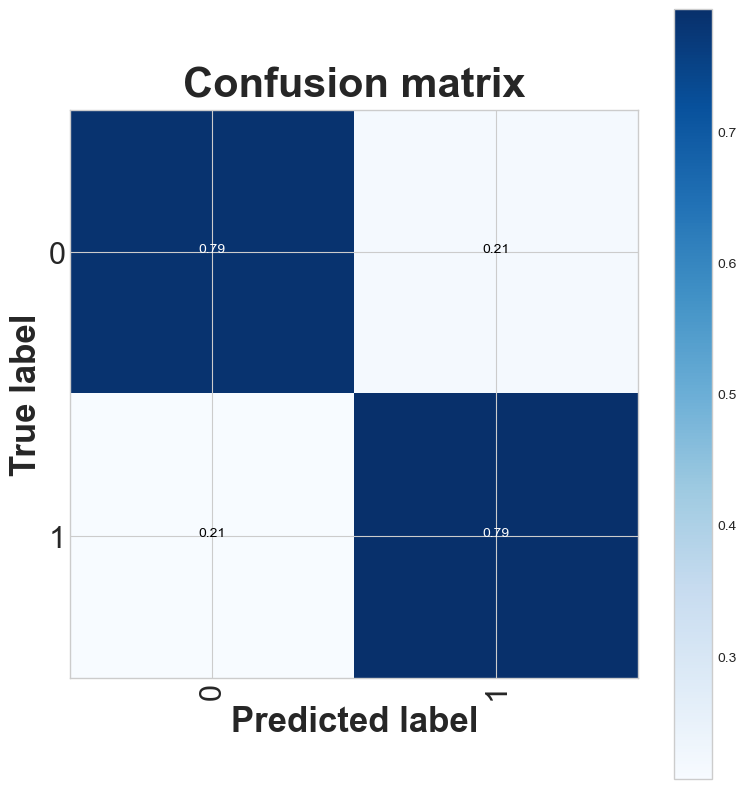

In [44]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes={0,1}, title="Confusion matrix")
plt.show()